In [1]:
import relational_image_generation_evaluation as rige

In [2]:
evaluator = rige.Evaluator('ViT-L/14')
dataloader_one = rige.get_one_edge_dataloader(testonly=True)
dataloader_two = rige.get_two_edge_dataloader(testonly=True)
dataloader_full = rige.get_full_graph_dataloader(testonly=True)
print("len(dataloader_one):", len(dataloader_one))
print("len(dataloader_two):", len(dataloader_two))

Using device cuda:4 for evaluation.
Using text embeddings as input to the model.
Loading filtered test graphs...
Finished loading filtered test graphs
Generating one edge graphs...


100%|██████████| 100/100 [00:00<00:00, 1072.89it/s]

Finished generating one edge graphs
Loading filtered test graphs...
Finished loading filtered test graphs
Generating two edge graphs...



100%|██████████| 100/100 [00:00<00:00, 810.07it/s]


Finished generating two edge graphs
Loading filtered test graphs...
Finished loading filtered test graphs
len(dataloader_one): 837
len(dataloader_two): 1076


Caption:long chair has silver, long legs.


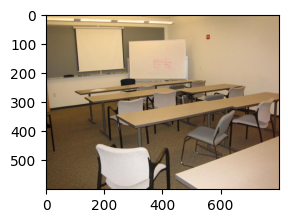

Caption:silver knife with handle.


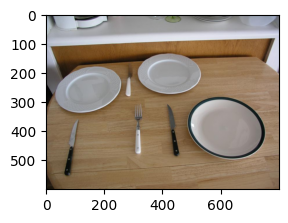

Caption:wooden, brown, wood cabinet has metal, silver handle.


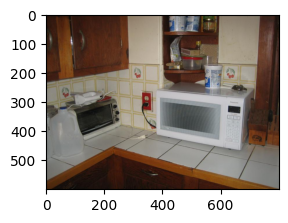

Caption:wood cabinet have glass.


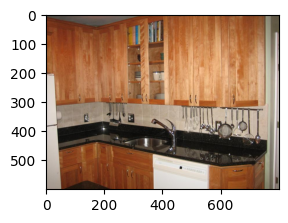

Caption:old, walking woman on sidewalk.


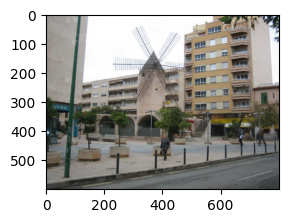

Caption:man wears striped shirt.


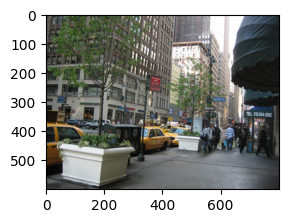

Caption:green grass next to paved street.


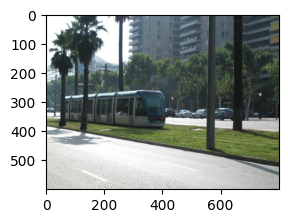

Caption:empty, brown chair at colored, brown table.


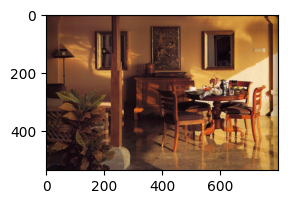

Caption:knife with a handle.


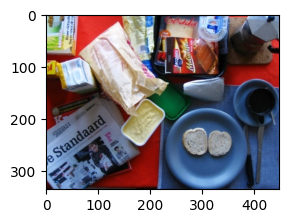

Caption:light on ceiling.


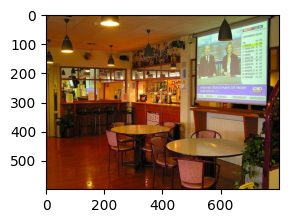

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_one))[0]
    print("Caption:" + graph.caption)
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # small figure size to fit in the notebook
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    images.append(image)
    graphs.append(graph)

In [4]:
scores = evaluator(images,graphs)
print(scores)
print(scores.keys())

{'rel_scores': [0.9999995231628418, 0.7317343950271606, 0.4569823145866394, 0.06368543952703476, 0.8973262906074524, 0.8224883675575256, 0.9924355149269104, 0.9842110276222229, 0.8108862638473511, 0.9772342443466187], 'attr_scores': [0.21502916514873505, 0.1272614449262619, 0.36680248379707336, 0.7951967120170593, 0.16157205402851105, 0.03386079892516136, 0.7046240568161011, 0.28223562240600586, 'noattributes', 'noattributes']}
dict_keys(['rel_scores', 'attr_scores'])


In [5]:
images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_two))[0]
    assert len(graph.edges) == 2, f"Graph does not have two edges: {graph.edges}"
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images.append(image)
    graphs.append(graph)

In [6]:
scores = evaluator(images,graphs)
print(scores)
print(scores.keys())

{'rel_scores': [0.9839267134666443, 0.9842110872268677, 0.9603124856948853, 0.9670870304107666, 0.9007983207702637, 0.4717627763748169, 0.9875704646110535, 0.4192347824573517, 0.7031576633453369, 0.9128290414810181], 'attr_scores': ['noattributes', 0.3004956841468811, 0.2872288227081299, 0.24860869348049164, 0.629729688167572, 0.26427629590034485, 'noattributes', 0.6687688231468201, 'noattributes', 0.5627623200416565]}
dict_keys(['rel_scores', 'attr_scores'])


In [7]:
from PIL import Image

images_orig = []
graphs_orig = []
images_adv = []
graphs_adv = []
for i in range(300):
    graph = next(iter(dataloader_one))[0]
    assert len(graph.edges) == 1, f"Graph does not have one edge: {graph.edges}"
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image_orig = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    image_adv = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images_orig.append(image_orig)
    graphs_orig.append(graph)
    graph_adv = rige.copy_graph(graph)
    # flip the attributes of the two nodes in the graph
    [n1,n2] = list(graph_adv.nodes)[0:2]
    graph_adv.nodes[n1]['attributes'], graph_adv.nodes[n2]['attributes'] = graph_adv.nodes[n2]['attributes'], graph_adv.nodes[n1]['attributes']
    images_adv.append(image_adv)
    graphs_adv.append(graph_adv)
scores_orig = evaluator(images_orig,graphs_orig)
scores_adv = evaluator(images_adv,graphs_adv)
print(scores_orig['attr_scores'])
print(scores_adv['attr_scores'])

['noattributes', 0.4038930833339691, 0.34000304341316223, 'noattributes', 'noattributes', 0.49560821056365967, 0.6687696576118469, 'noattributes', 0.26091229915618896, 0.7256128787994385, 0.45577579736709595, 'noattributes', 0.23195184767246246, 0.6983509063720703, 'noattributes', 0.698350727558136, 0.7514296770095825, 0.02600022405385971, 0.5323565006256104, 0.2779780626296997, 'noattributes', 'noattributes', 0.3348170518875122, 0.32489603757858276, 0.04191867634654045, 0.34666740894317627, 'noattributes', 0.09917963296175003, 0.5026042461395264, 'noattributes', 0.5526729226112366, 0.5060549378395081, 'noattributes', 'noattributes', 0.031772155314683914, 'noattributes', 'noattributes', 0.1133190244436264, 0.009956445544958115, 'noattributes', 0.9745047688484192, 0.11902481317520142, 0.001042969524860382, 0.12137679010629654, 0.01459724921733141, 0.5143182873725891, 0.5008362531661987, 0.03177215903997421, 'noattributes', 'noattributes', 0.49683260917663574, 0.000724100274965167, 0.285

In [8]:
# print how often the model was more confident in the good graph
n_good = 0
n_bad = 0
for orig,adv in zip(scores_orig['attr_scores'],scores_adv['attr_scores']):
    if orig == 'noattributes':
        continue
    if orig == adv:
        n_good += 0.5
        print("warning, this is unlikely to happen")
    elif orig>adv:
        n_good += 1
    else:
        n_bad += 1

print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

warning, this is unlikely to happen
n_correct: 172.5, n_incorrect: 25, accuracy: 0.8734177215189873
